# Deep Feature-Based Text Clustering and Its Explanation

This notebook is a reproduction of the paper *"Deep Feature-Based Text Clustering and its Explanation"* by Guan et al. (IEEE TKDE, 2022).

The paper addresses the limitations of traditional text clustering approaches, which are usually based on the bag-of-words representation and suffer from high dimensionality, sparsity, and lack of contextual/sequence information.

The authors propose a novel framework called **Deep Feature-Based Text Clustering (DFTC)** that leverages pretrained deep text encoders (ELMo and InferSent) to generate contextualized sentence/document embeddings. These embeddings are then normalized and clustered using classical algorithms such as K-means.

Additionally, the paper introduces the **Text Clustering Results Explanation (TCRE)** module, which applies a logistic regression model on bag-of-words features with pseudo-labels derived from clustering. This allows the extraction of *indication words* that explain the semantics of each cluster, providing interpretability and qualitative evaluation of the results.

Experiments on multiple benchmark datasets (AG News, DBpedia, Yahoo! Answers, Reuters) demonstrate that the proposed framework outperforms traditional clustering methods (tf-idf+KMeans, LDA, GSDMM), deep clustering models (DEC, IDEC, STC), and even BERT in most cases. The combination of **deep semantic features + interpretability** makes DFTC an effective and transparent solution for unsupervised text clustering.

---

### DFTC framework overview

Below is the overall architecture of the proposed framework from the paper:

![DFTC Framework](DFTC_framework.png)

*Figure: Deep Feature-Based Text Clustering (DFTC) framework. First, pretrained encoders generate document embeddings. Then, features are normalized and clustered. Finally, the TCRE module explains the clusters by identifying indication words.*


In [1]:
# --- Core Python ---
import os
import io
import re
import zipfile
import requests

# --- Scientific & ML libraries ---
import numpy as np
import torch
import tensorflow as tf
import tensorflow_hub as hub
from transformers import AutoTokenizer, AutoModel

# --- NLP ---
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

# --- Machine Learning & Clustering ---
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.optimize import linear_sum_assignment

# --- Visualization ---
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Datasets ---
from datasets import load_dataset
import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# Load pre trained ELMo model

elmo = hub.load("https://tfhub.dev/google/elmo/3")
print(elmo.signatures['default'].structured_outputs)

{'lstm_outputs1': <tf.Tensor 'concat:0' shape=(None, None, 1024) dtype=float32>, 'lstm_outputs2': <tf.Tensor 'concat_1:0' shape=(None, None, 1024) dtype=float32>, 'word_emb': <tf.Tensor 'bilm/Reshape_1:0' shape=(None, None, 512) dtype=float32>, 'elmo': <tf.Tensor 'aggregation/mul_3:0' shape=(None, None, 1024) dtype=float32>, 'sequence_len': <tf.Tensor 'Sum:0' shape=(None,) dtype=int32>, 'default': <tf.Tensor 'truediv:0' shape=(None, 1024) dtype=float32>}


In [ ]:
# Clone git repository
!git clone https://github.com/facebookresearch/InferSent.git

# Open the InferSent directory
%cd InferSent

# Install dependencies
!pip install torch torchvision nltk

# Download the pre-trained InferSent model
!wget https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

# Download word embeddings (GloVe)
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip -q glove.840B.300d.zip

In [ ]:
from models import InferSent

# Model parameters
MODEL_PATH = 'infersent2.pkl'
params_model = {
    'bsize': 64,
    'word_emb_dim': 300,
    'enc_lstm_dim': 2048,
    'pool_type': 'max',
    'dpout_model': 0.0,
    'version': 2
}
infer_model = InferSent(params_model)
infer_model.load_state_dict(torch.load(MODEL_PATH))

# GloVe embedding
W2V_PATH = 'glove.840B.300d.txt'
infer_model.set_w2v_path(W2V_PATH)

# Example usage
sentences = ["This is a sentence.", "This is another sentence."]
infer_model.build_vocab(sentences, tokenize=True)
embeddings = infer_model.encode(sentences, tokenize=True)

print(embeddings.shape)
print(embeddings[0][:10]) # Show first 10 elements

Found 8(/8) words with w2v vectors
Vocab size : 8
(2, 4096)
[ 0.01817451  0.04943118 -0.03883769  0.02026917  0.02907335  0.03138965
  0.05418633 -0.08393945 -0.00739952  0.02362865]


## Step 1: Feature Construction

This step constructs fixed-length document representations using pretrained neural encoders, namely **ELMo** and **InferSent**, which are employed as feature extractors without further fine-tuning.

- **ELMo**  
  ELMo provides contextualized word representations based on a deep **bidirectional LSTM language model**. Given a document, token-level embeddings are first computed and subsequently aggregated through pooling operations (e.g., mean or max pooling) to obtain a single document-level vector. The resulting representation has dimensionality **1024**.

- **InferSent**  
  InferSent is a supervised sentence encoder trained on Natural Language Inference (NLI) data. It encodes sentences using a **BiLSTM architecture with max pooling**, producing semantically informative sentence embeddings. For multi-sentence documents, sentence-level embeddings are averaged to derive a document representation of dimensionality **4096**.

The output of this step is a feature matrix **X ∈ ℝⁿˣᵈ**, where *n* denotes the number of documents and *d* depends on the selected encoder. These representations are subsequently normalized and used for downstream tasks such as **K-means clustering**.


In [3]:
def clean_for_infersent(texts):
    clean_texts = []
    for t in texts:
        if t is None:
            continue
        if isinstance(t, (list, tuple)):
            t = " ".join(map(str, t))
        t = str(t).strip()
        if len(t) == 0:
            continue
        clean_texts.append(t)
    return clean_texts

In [4]:
def extract_features(texts, model='elmo', pooling='mean', batch_size=64):
    """
    Extract deep feature representations for a list of texts using ELMo or InferSent.

    Args:
        texts (list of str): List of input documents.
        model (str): 'elmo' or 'infersent' to choose the embedding model.
        pooling (str): Pooling strategy for ELMo ('mean', 'max', 'last').
        batch_size (int): Batch size for processing texts with ELMo.

    Returns:
        np.ndarray: Matrix of shape (n_docs, d) with document embeddings.
    """
    if model == 'elmo':
        doc_embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i : i + batch_size]
            batch_tokens = [word_tokenize(text) for text in batch_texts]

            # Pad sequences to the maximum length in the batch
            max_len = max(len(tokens) for tokens in batch_tokens)
            padded_tokens = tf.constant([
                tokens + [''] * (max_len - len(tokens)) for tokens in batch_tokens
            ], dtype=tf.string)
            sequence_lengths = tf.constant([len(tokens) for tokens in batch_tokens], dtype=tf.int32)

            # Get ELMo outputs using tokens signature
            outputs = elmo.signatures["tokens"](tokens=padded_tokens, sequence_len=sequence_lengths)
            embeddings = outputs["lstm_outputs2"]  # last LSTM layer

            # Apply pooling along token axis (axis=1)
            batch_embeddings = []
            for j in range(len(batch_texts)):
                seq_len = sequence_lengths[j].numpy()
                seq_embeddings = embeddings[j, :seq_len, :] # Select non-padded embeddings

                if pooling == 'mean':
                    doc_embedding = tf.reduce_mean(seq_embeddings, axis=0).numpy()
                elif pooling == 'max':
                    doc_embedding = tf.reduce_max(seq_embeddings, axis=0).numpy()
                elif pooling == 'last':
                    doc_embedding = seq_embeddings[-1, :].numpy()
                else:
                    raise ValueError("Invalid pooling method.")
                batch_embeddings.append(doc_embedding)
            doc_embeddings.extend(batch_embeddings)

        return np.array(doc_embeddings)

    elif model == 'infersent':
        # Assuming InferSent model is loaded and configured
        infersent.build_vocab(texts, tokenize=True)
        doc_embeddings = infersent.encode(texts, tokenize=True)

    else:
        raise ValueError("Model must be 'elmo' or 'infersent'.")

    return doc_embeddings

In [5]:
def normalize_features(X, method='l2', eps=1e-10):
    """
    Normalize feature matrix X using specified method.

    Args:
        X (np.ndarray): Input feature matrix of shape (n_samples, n_features).
        method (str): Normalization method. One of:
                      'identity'  -> no normalization
                      'l2'        -> L2 normalization (unit length)
                      'layernorm' -> normalize each vector by mean and std
        eps (float): Small constant to avoid division by zero.

    Returns:
        np.ndarray: Normalized feature matrix.
    """
    if method == 'identity':
        return X
    elif method == 'l2':
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        return X / (norms + eps)
    elif method == 'layernorm':
        means = np.mean(X, axis=1, keepdims=True)
        stds = np.std(X, axis=1, keepdims=True)
        return (X - means) / (stds + eps)
    else:
        raise ValueError("Invalid normalization method.")

## Step 2: Clustering

In this step, clustering algorithms are applied to the **normalized deep feature representations** obtained in Step 1. The objective is to group documents into clusters based on semantic similarity in the embedding space.

**K-means** is adopted as the primary clustering method due to its simplicity and effectiveness in high-dimensional vector spaces. Alternative approaches, such as **Agglomerative Clustering** or **DBSCAN**, may also be considered to capture different structural properties of the data.

The output of this step consists of a cluster assignment for each document. These assignments are subsequently used in the following step to support the generation of cluster-level explanations.


In [15]:
def cluster_features(X, n_clusters, method="kmeans", random_state=111):
    """
    Cluster the feature matrix using different clustering algorithms.

    Args:
        X (np.ndarray): Normalized feature matrix of shape (n_samples, d).
        n_clusters (int): Number of clusters to find (usually equal to the number of classes).
        method (str): Clustering method to use ("kmeans" or "agglomerative").
        random_state (int): Random seed for reproducibility (used only for K-means).

    Returns:
        np.ndarray: Cluster assignments of shape (n_samples,).
        object: Fitted clustering model.
    """
    method = method.lower()

    if method == "kmeans":
        model = KMeans(
            n_clusters=n_clusters,
            init="k-means++",
            n_init=20,
            max_iter=300,
            random_state=random_state
        )
        y_pred = model.fit_predict(X)

    elif method == "agglomerative":
        model = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage="ward", # better metrics than complete
            #metric="cosine"
        )
        y_pred = model.fit_predict(X)

    else:
        raise ValueError(
            f"Unknown clustering method '{method}'. "
            "Supported methods are 'kmeans' and 'agglomerative'."
        )

    return y_pred, model


## Step 3: Evaluation Metrics

Clustering performance is assessed using three standard evaluation metrics commonly adopted in the literature: **Clustering Accuracy (ACC)**, **Normalized Mutual Information (NMI)**, and **Adjusted Rand Index (ARI)**. These metrics compare the predicted cluster assignments with the available ground-truth labels and provide complementary perspectives on clustering quality.

- **Clustering Accuracy (ACC)**  
  Clustering Accuracy measures the best possible alignment between predicted clusters and true labels. Since cluster indices are permutation-invariant, the optimal one-to-one mapping between clusters and labels is obtained using the **Hungarian algorithm**.  
  Formally, ACC is defined as:
  $$
  \mathrm{ACC} = \frac{1}{n} \max_{m} \sum_{i=1}^{n} \mathbf{1}\{ l_i = m(c_i) \},
  $$
  where $l_i$ denotes the ground-truth label of document $i$, $c_i$ is its cluster assignment, $m(\cdot)$ is a mapping from clusters to labels, and $n$ is the number of documents.

- **Normalized Mutual Information (NMI)**  
  NMI measures the mutual dependence between the cluster assignments $C$ and the true labels $L$, and is normalized to account for scale differences. Its value ranges from 0 (no mutual information) to 1 (perfect agreement).  
  NMI is defined as:
  $$
  \mathrm{NMI}(L, C) = \frac{\mathrm{MI}(L, C)}{\sqrt{H(L)\,H(C)}},
  $$
  where $\mathrm{MI}(\cdot,\cdot)$ denotes mutual information and $H(\cdot)$ denotes entropy.

- **Adjusted Rand Index (ARI)**  
  ARI evaluates the similarity between two partitions by considering all pairs of samples and counting pairs that are assigned consistently in both clusterings, while adjusting for chance. The metric ranges from $-1$ to 1, with 1 indicating perfect agreement.  
  ARI is defined as:
  $$
  \mathrm{ARI} =
  \frac{
    \sum_{i,j} \binom{n_{ij}}{2}
    - \frac{
        \sum_i \binom{n_i}{2} \sum_j \binom{n_j}{2}
      }{\binom{n}{2}}
  }{
    \frac{1}{2}
    \left[
      \sum_i \binom{n_i}{2} + \sum_j \binom{n_j}{2}
    \right]
    - \frac{
        \sum_i \binom{n_i}{2} \sum_j \binom{n_j}{2}
      }{\binom{n}{2}}
  },
  $$
  where $n$ is the number of all instances, $n_{ij}$ is the number of instances appearing in the $i$th predicted label and $j$th ground-truth label, $n_i$ is the number of ith predicted label instances, and $n_j$ is the number of $j$th ground-truth label instances.

Together, these metrics provide a comprehensive evaluation of clustering quality by capturing label alignment (ACC), shared information (NMI), and agreement corrected for random chance (ARI).


In [7]:
def clustering_accuracy(y_true, y_pred):
    """
    Compute clustering accuracy (ACC) with Hungarian algorithm.

    Args:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted cluster assignments.

    Returns:
        float: Clustering accuracy in [0,1].
    """
    y_true = np.asarray(y_true).astype(np.int64)
    y_pred = np.asarray(y_pred).astype(np.int64)
    assert y_pred.shape == y_true.shape

    D = max(y_pred.max(), y_true.max()) + 3
    w = np.zeros((D, D), dtype=np.int64)

    # Build confusion matrix
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    # Hungarian algorithm for optimal assignment
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    mapping = dict(zip(row_ind, col_ind))

    # Apply mapping
    y_pred_mapped = np.array([mapping[c] for c in y_pred])
    return np.mean(y_true == y_pred_mapped)


def clustering_nmi(y_true, y_pred):
    """
    Compute Normalized Mutual Information (NMI).
    """
    return normalized_mutual_info_score(y_true, y_pred)


def clustering_ari(y_true, y_pred):
    """
    Compute Adjusted Rand Index (ARI).
    """
    return adjusted_rand_score(y_true, y_pred)


## Step 4: Feature Visualization

To qualitatively assess the quality of the extracted representations, high-dimensional document embeddings are projected into a two-dimensional space and visually inspected.

The projection is performed using **t-distributed Stochastic Neighbor Embedding (t-SNE)**, a nonlinear dimensionality reduction technique designed to preserve local neighborhood structures in the original feature space.

If the learned representations are informative, documents belonging to the same class are expected to form compact and coherent clusters in the two-dimensional visualization, while samples from different classes should appear well separated.

This qualitative analysis provides additional insight into the discriminative power of the embeddings produced by **ELMo** and **InferSent**, and allows for a direct comparison with traditional representations.


In [8]:
def visualize_features(X, labels, title="t-SNE Feature Visualization", n_samples=2000, random_state=42):
    """
    Visualize document embeddings in 2D using t-SNE.

    Args:
        X (np.ndarray): Feature matrix of shape (n_samples, d).
        labels (array-like): Ground truth or predicted cluster labels.
        title (str): Plot title.
        n_samples (int): Max number of points to visualize (for efficiency).
        random_state (int): Random seed for reproducibility.
    """
    # Subsample for faster visualization if dataset is large
    if X.shape[0] > n_samples:
        idx = np.random.choice(X.shape[0], n_samples, replace=False)
        X = X[idx]
        labels = np.array(labels)[idx]

    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,
                max_iter=1000, random_state=random_state, init="pca")
    X_2d = tsne.fit_transform(X)

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab10", alpha=0.7, s=15)
    plt.title(title)
    plt.colorbar(scatter, label="Class/Cluster")
    plt.show()


## Step 5: Dataset Loading

This section describes the preparation of the benchmark datasets used in the experimental evaluation.

The following datasets are considered:
- **AG News**, consisting of 4 topical classes of news articles;
- **DBpedia**, containing 14 ontology-based categories;
- **Yahoo! Answers**, composed of 10 question–answer categories;
- **Reuters (R2 / R5 subsets)**, including 2 or 5 classes extracted from the Reuters-21578 corpus.

Due to the large size of these datasets, experiments are conducted either on the full corpora or on balanced subsets, following the experimental protocol described in the reference paper (e.g., 1000 samples per class for AG News, DBpedia, and Yahoo! Answers).

Each dataset is loaded and preprocessed through standard text normalization steps, including tokenization, lowercasing, and optional stopword removal. The processed data are organized into two components:
- **texts**, containing the raw document content;
- **labels**, containing the corresponding ground-truth class annotations.

These components constitute the input to the subsequent feature extraction and clustering pipeline.


In [9]:
def clean_text(text):
    """Basic preprocessing: lowercase and remove HTML tags."""
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)  # remove html
    text = re.sub(r"\s+", " ", text).strip()
    return text

def load_agnews(n_per_class=1000):
    dataset = load_dataset("ag_news")
    texts, labels = [], []
    for label in range(4):
        samples = dataset["train"].filter(lambda x: x["label"] == label).select(range(n_per_class))
        texts.extend([clean_text(t) for t in samples["text"]])
        labels.extend(samples["label"])
    return texts, labels

def load_dbpedia(n_per_class=1000):
    dataset = load_dataset("dbpedia_14")
    texts, labels = [], []
    for label in range(14):
        samples = dataset["train"].filter(lambda x: x["label"] == label).select(range(n_per_class))
        texts.extend([clean_text(t) for t in samples["content"]])
        labels.extend(samples["label"])
    return texts, labels

def load_yahoo(n_per_class=1000):
    dataset = load_dataset("yahoo_answers_topics")
    texts, labels = [], []
    for label in range(10):
        samples = dataset["train"].filter(lambda x: x["topic"] == label).select(range(n_per_class))
        # Concatenate question + best answer as in the paper
        texts.extend([clean_text(q + " " + a) for q, a in zip(samples["question_title"], samples["best_answer"])])
        labels.extend(samples["topic"])
    return texts, labels

def load_reuters(subset="R2"):
    # Reuters-21578 is available in nltk, but HuggingFace also has reuters21578
    dataset = load_dataset("reuters21578")
    docs, labels = dataset["train"]["text"], dataset["train"]["label"]

    # Clean documents
    docs = [clean_text(t) for t in docs]

    if subset == "R2":
        # Earn vs Acq
        mask = [l in ["earn", "acq"] for l in labels]
        texts = [docs[i] for i in range(len(docs)) if mask[i]]
        y = [0 if labels[i] == "earn" else 1 for i in range(len(docs)) if mask[i]]
    elif subset == "R5":
        target_labels = ["earn", "acq", "crude", "trade", "money-fx"]
        mapping = {lab: idx for idx, lab in enumerate(target_labels)}
        mask = [l in target_labels for l in labels]
        texts = [docs[i] for i in range(len(docs)) if mask[i]]
        y = [mapping[labels[i]] for i in range(len(docs)) if mask[i]]
    else:
        raise ValueError("subset must be 'R2' or 'R5'")

    return texts, y

In [10]:
def load_reuters(subset='R2'):
    """
    Load and preprocess Reuters dataset (R2 or R5 subset).

    Args:
        subset (str): 'R2' for 2 classes, 'R5' for 5 classes.

    Returns:
        texts (list of str): List of documents.
        labels (list of int): Corresponding class labels.
    """
    dataset = load_dataset('reuters21578', 'ModApte', split='train')
    if subset == 'R2':
        # Binary classification: 'earn' vs 'acq'
        texts, labels = [], []
        for item in dataset:
            if 'earn' in item['topics']:
                texts.append(clean_text(item['text']))
                labels.append(0)
            elif 'acq' in item['topics']:
                texts.append(clean_text(item['text']))
                labels.append(1)
        return texts, labels
    elif subset == 'R5':
        # 5 classes: 'earn', 'acq', 'crude', 'trade', 'money-fx'
        class_map = {'earn': 0, 'acq': 1, 'crude': 2, 'trade': 3, 'money-fx': 4}
        texts, labels = [], []
        for item in dataset:
            for topic in item['topics']:
                if topic in class_map:
                    texts.append(clean_text(item['text']))
                    labels.append(class_map[topic])
                    break
        return texts, labels
    else:
        raise ValueError("Subset must be 'R2' or 'R5'.")

## Step 6: Experiments

This section describes the experimental protocol adopted to replicate the setup proposed in *Deep Feature-Based Text Clustering and its Explanation*.

The objective is to analyze the impact of different design choices on clustering performance. In particular, the following factors are investigated:
- **Embedding model**: ELMo (language model–based embeddings) or InferSent;
- **Pooling strategy**: mean, max, or last pooling applied to token-level representations;
- **Normalization**: identity (I), $\ell_2$ normalization (N), or Layer Normalization (LN);
- **Clustering algorithm**: K-means (KM).


Clustering performance is evaluated using the metrics introduced in the previous section, namely **Clustering Accuracy (ACC)**, **Normalized Mutual Information (NMI)**, and **Adjusted Rand Index (ARI)**.

---


## 6.1 Experiments with ELMo (LM)

This section focuses on experiments conducted using **ELMo**, based on language model (LM) representations. For each dataset, document embeddings are obtained by applying **mean pooling** to the token-level representations extracted from the last ELMo layer. Different normalization strategies are then applied, and the resulting features are clustered using **K-means (KM)**.

### Experiment 1: LM + Mean + LN + KM (AG News)

In this experiment, **Layer Normalization (LN)** is applied to mean-pooled ELMo embeddings obtained from the AG News dataset. The normalized representations are subsequently clustered using K-means.

### Experiment 2: LM + Mean + I + KM (DBpedia)

This experiment evaluates the effect of **Identity normalization (I)**, i.e., no normalization, on mean-pooled ELMo embeddings extracted from the DBpedia dataset, followed by K-means clustering.

### Experiment 3: LM + Mean + N + KM (AG News, DBpedia, Yahoo! Answers)

In this setting, **$\ell_2$ normalization (N)** is applied to mean-pooled ELMo embeddings. Clustering performance is analyzed across three datasets: AG News, DBpedia, and Yahoo! Answers.


Results on AG News (ELMo + Mean + LayerNorm + KMeans):
ACC: 83.08%
NMI: 58.70%
ARI: 61.37%


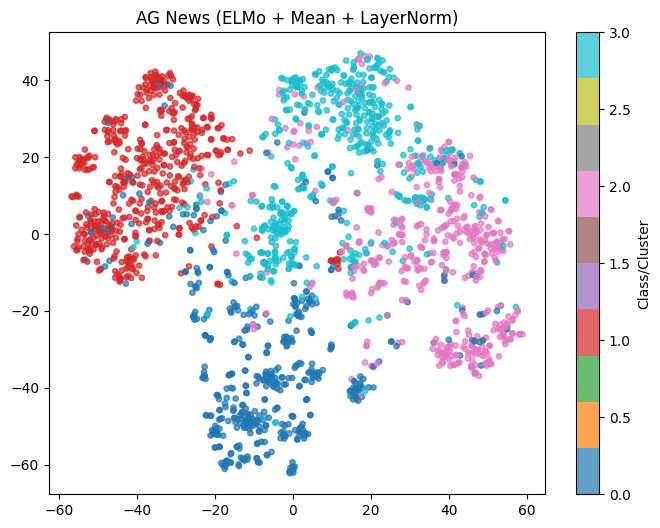

In [ ]:
# Experiment 1: LM + Mean + LN + KM on AG News
texts, labels = load_agnews(n_per_class=1000)

X = extract_features(texts, model='elmo', pooling='mean')
X_norm = normalize_features(X, method="layernorm")
y_pred, _ = cluster_features(X_norm, n_clusters=4)

acc = clustering_accuracy(labels, y_pred)
nmi = clustering_nmi(labels, y_pred)
ari = clustering_ari(labels, y_pred)

print(f"Results on AG News (ELMo + Mean + LayerNorm + KMeans):")
print(f"ACC: {acc*100:.2f}%")
print(f"NMI: {nmi*100:.2f}%")
print(f"ARI: {ari*100:.2f}%")

# Plot feature visualization
visualize_features(X_norm, labels, title='AG News (ELMo + Mean + LayerNorm)')

Results on DBpedia (ELMo + Mean + Identity + KMeans):
ACC: 74.34%
NMI: 75.39%
ARI: 65.56%


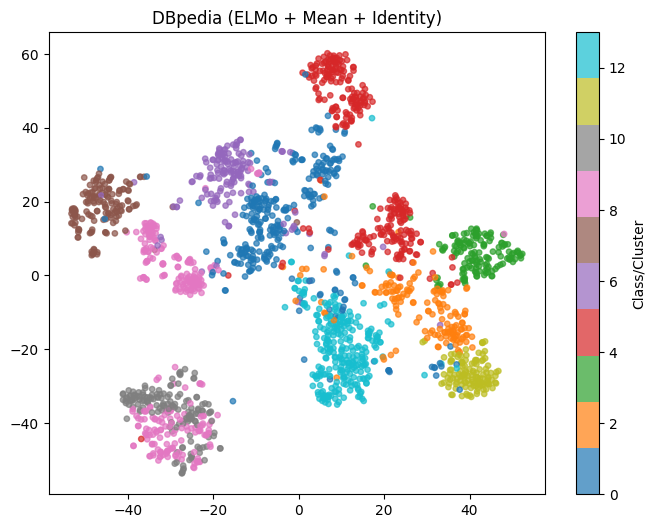

In [ ]:
# Experiment 2: LM + Mean + I + KM on DBpedia
texts, labels = load_dbpedia(n_per_class=1000)

X = extract_features(texts, model='elmo', pooling='mean')
X_norm = normalize_features(X, method="identity")
y_pred , _ = cluster_features(X_norm, n_clusters=14)

acc = clustering_accuracy(labels, y_pred)
nmi = clustering_nmi(labels, y_pred)
ari = clustering_ari(labels, y_pred)

print(f"Results on DBpedia (ELMo + Mean + Identity + KMeans):")
print(f"ACC: {acc*100:.2f}%")
print(f"NMI: {nmi*100:.2f}%")
print(f"ARI: {ari*100:.2f}%")

# Plot feature visualization
visualize_features(X_norm, labels, title='DBpedia (ELMo + Mean + Identity)')

Results on AG News (ELMo + Mean + L2 + KMeans):
ACC: 82.97%
NMI: 58.59%
ARI: 61.21%


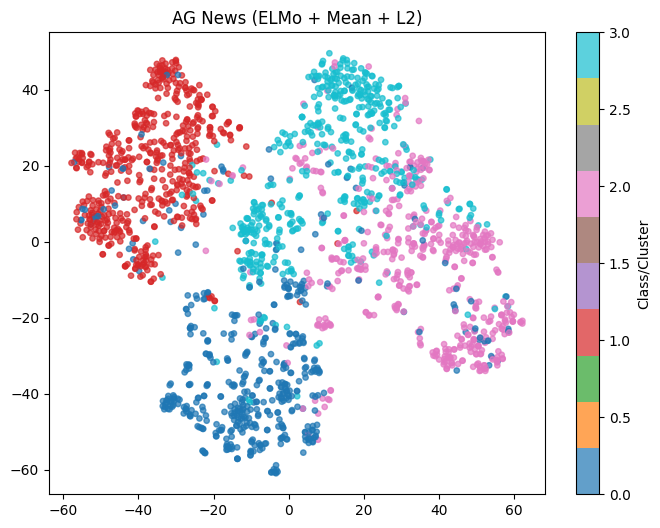

Results on DBpedia (ELMo + Mean + L2 + KMeans):
ACC: 74.46%
NMI: 75.64%
ARI: 64.71%


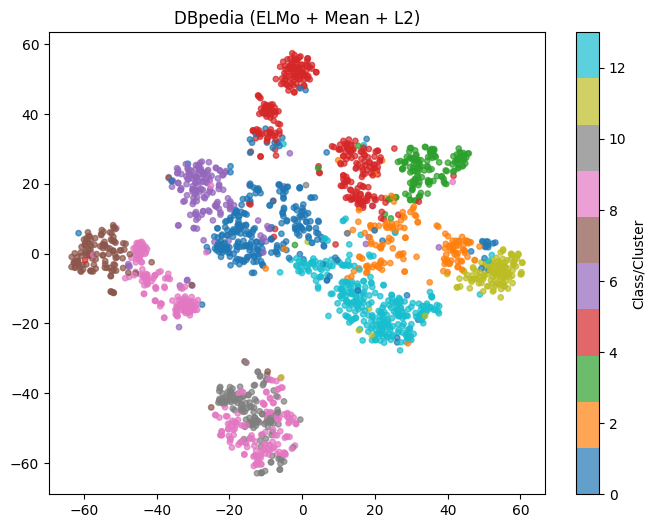

In [ ]:
# Experiment 3: LM + Mean + N + KM on AG News, DBpedia, and Yahoo Answers
for dataset_name, load_func, n_clusters, n_samples in [
    ('AG News', load_agnews, 4, 1000),
    ('DBpedia', load_dbpedia, 14, 1000),
    #('Yahoo Answers', load_yahoo, 10, 1000) # too big for Colab
]:
    texts, labels = load_func(n_per_class=n_samples)
    X = extract_features(texts, model='elmo', pooling='mean')
    X_norm = normalize_features(X, method="l2")
    y_pred, _ = cluster_features(X_norm, n_clusters=n_clusters)

    acc = clustering_accuracy(labels, y_pred)
    nmi = clustering_nmi(labels, y_pred)
    ari = clustering_ari(labels, y_pred)

    print(f"Results on {dataset_name} (ELMo + Mean + L2 + KMeans):")
    print(f"ACC: {acc*100:.2f}%")
    print(f"NMI: {nmi*100:.2f}%")
    print(f"ARI: {ari*100:.2f}%")

    # Plot feature visualization
    visualize_features(X_norm, labels, title=f'{dataset_name} (ELMo + Mean + L2)')

## 6.2 Experiments with InferSent

This section evaluates the performance of **InferSent**, a sentence embedding model trained on Natural Language Inference (NLI) data. Unlike ELMo, InferSent generates fixed-size sentence embeddings of 4096 dimensions, allowing for straightforward feature extraction. Two normalization strategies are applied prior to K-means clustering.

### Experiment 4: InferSent + LN + KM (DBpedia)

In this experiment, **Layer Normalization (LN)** is applied to InferSent embeddings extracted from the DBpedia dataset, followed by clustering with K-means.

### Experiment 5: InferSent + N + KM (AG News)

Here, **$\ell_2$ normalization (N)** is applied to InferSent embeddings obtained from AG News, and the resulting vectors are clustered using K-means.


In [ ]:
# sentences = np.array(list(sentences), dtype=object)[idx_sort] in models.py (line 207)
dataset = load_dataset("ag_news")

# conversion to strings
def to_single_string(x):
    if isinstance(x, (list, tuple)):
        return " ".join(map(str, x))
    return str(x)

train_texts = [to_single_string(x) for x in dataset["train"]["text"]]
train_labels = np.array(dataset["train"]["label"])

test_texts = [to_single_string(x) for x in dataset["test"]["text"]]
test_labels = np.array(dataset["test"]["label"])

# Build vocabulary
print("Building vocabulary on training set...")
infer_model.build_vocab(train_texts, tokenize=True)

# Sentence-by-sentence encoding function
def encode_one_by_one(texts, tokenize=True):
    all_embeddings = []
    for sent in texts:
        emb = infer_model.encode([sent], tokenize=tokenize)  # batch = 1
        if isinstance(emb, list):
            emb = np.vstack(emb)
        all_embeddings.append(emb)
    return np.vstack(all_embeddings)

# Extract train and test embeddings
print("Extract train embeddings (batch 1)...")
train_embeddings = encode_one_by_one(train_texts, tokenize=True)
print("Train embeddings:", train_embeddings.shape)

print("Extract test embeddings (batch 1)...")
test_embeddings = encode_one_by_one(test_texts, tokenize=True)
print("Test embeddings:", test_embeddings.shape)

Building vocabulary on training set...
Found 95522(/124679) words with w2v vectors
Vocab size : 95522
Extract train embeddings (batch 1)...


KeyboardInterrupt: 

In [ ]:
# Experiment 4: InferSent + LN + KM on DBpedia
texts, labels = load_dbpedia(n_per_class=1000)

#infer_model.build_vocab(texts, tokenize=True)
#X = infer_model.encode(texts, tokenize=True)
X = extract_features(texts, model='infersent')
#embeddings = infer_model.encode(texts, tokenize=True)

X_norm = normalize_features(X, method="layernorm")
y_pred, _ = cluster_features(X_norm, n_clusters=14)

acc = clustering_accuracy(labels, y_pred)
nmi = clustering_nmi(labels, y_pred)
ari = clustering_ari(labels, y_pred)

print(f"Results on DBpedia (InferSent + LayerNorm + KMeans):")
print(f"ACC: {acc*100:.2f}%")
print(f"NMI: {nmi*100:.2f}%")
print(f"ARI: {ari*100:.2f}%")

# Plot feature visualization
visualize_features(X_norm, labels, title='DBpedia (InferSent + LayerNorm)')

Found 39576(/68999) words with w2v vectors
Vocab size : 39576


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (64,) + inhomogeneous part.

In [ ]:
# Experiment 5: InferSent + N + KM on AG News
texts, labels = load_ag_news(n_per_class=1000)

X = extract_features(texts, model='infersent')
X_norm = normalize_features(X, method="l2")
y_pred, _ = cluster_features(X_norm, n_clusters=14)

acc = clustering_accuracy(labels, y_pred)
nmi = clustering_nmi(labels, y_pred)
ari = clustering_ari(labels, y_pred)

print(f"Results on AG News (InferSent + L2 + KMeans):")
print(f"ACC: {acc*100:.2f}%")
print(f"NMI: {nmi*100:.2f}%")
print(f"ARI: {ari*100:.2f}%")

# Plot feature visualization
visualize_features(X_norm, labels, title='AG News (InferSent + L2)')

## Step 7: Explainability – TCRE Model

To interpret the clusters obtained in the previous steps, the **Text Clustering Result Explanation (TCRE)** model is employed. The method identifies **indication words** that best characterize each cluster, providing a human-interpretable explanation of the clustering results.

The procedure, corresponding to Algorithm 1 in the reference paper, is as follows:

1. Each document is converted into a **binary bag-of-words vector**, where entries indicate the presence ($1$) or absence ($0$) of a word.
2. Stop words and low-frequency terms are removed to reduce noise.
3. A **logistic regression classifier** is trained using the cluster assignments as pseudo-labels.
4. The absolute values of the learned regression weights are examined to identify the **most informative words** for each cluster.

The output of the TCRE model is, for each cluster, a ranked list of indication words that captures the semantic content of the cluster.


In [17]:
def tcre_explanation(corpus, cluster_labels, top_n=10, min_df=5, stop_words='english'):
    """
    Text Clustering Result Explanation (TCRE):
    Identify indication words for each cluster.

    Args:
        corpus (list of str): List of documents (raw text).
        cluster_labels (array-like): Cluster assignments for each document.
        top_n (int): Number of top indication words per cluster.
        min_df (int): Minimum document frequency for a word to be kept.
        stop_words (str or list): Stop words to remove.

    Returns:
        dict: {cluster_id: [indication words]}
    """
    # Convert documents to binary bag-of-words features
    vectorizer = CountVectorizer(binary=True, stop_words=stop_words, min_df=min_df)
    X = vectorizer.fit_transform(corpus)
    vocab = np.array(vectorizer.get_feature_names_out())

    # Train logistic regression with pseudo-labels
    clf = LogisticRegression(max_iter=1000, multi_class='ovr')
    clf.fit(X, cluster_labels)

    # For each cluster, get top absolute-weight words
    ind_words = {}
    weights = clf.coef_  # shape (n_clusters, n_features)

    for cluster_id, w in enumerate(weights):
        abs_w = np.abs(w)
        top_idx = np.argsort(abs_w)[::-1][:top_n]
        ind_words[cluster_id] = vocab[top_idx].tolist()

    return ind_words


In [ ]:
indication_words = tcre_explanation(texts, y_pred, top_n=10)

for cluster, words in indication_words.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Cluster 0: space, scientists, sunday, study, afp, shares, iraq, video, profit, software
Cluster 1: oil, shares, market, profit, quarter, investors, stocks, july, earnings, airline
Cluster 2: minister, iraq, leader, president, israel, police, india, rebels, terrorist, political
Cluster 3: athens, olympics, champion, coach, league, olympic, night, victory, company, gold


## 6.3 Experiments with BERT

The evaluation is extended to a Transformer-based pretrained encoder, **BERT (bert-base-uncased)**, used as a feature extractor for clustering. BERT is a recent, bidirectional Transformer model that generates context-aware embeddings, capturing complex semantic and syntactic relationships across tokens. Its deep pretrained representations have been shown to achieve state-of-the-art performance on a wide range of NLP tasks, making it a strong candidate for clustering applications.

Document embeddings are obtained from the **last hidden states** of BERT, followed by **max pooling** over the token dimension. Each resulting vector is normalized using **Layer Normalization (LN)** prior to clustering. Clustering is performed with **K-means (KM)** using $n_{init}=20$.

Experiments are conducted on **AG News** and **DBpedia** datasets. Clustering performance is evaluated using the metrics introduced previously: **Clustering Accuracy (ACC)**, **Normalized Mutual Information (NMI)**, and **Adjusted Rand Index (ARI)**.


In [ ]:
# Ensure deterministic behavior where possible
torch.manual_seed(42)
np.random.seed(42)

def bert_max_pool_embeddings(texts, model_name="bert-base-uncased", batch_size=32, device=None):
    """
    Extract max-pooled BERT embeddings for a list of texts.
    Uses last_hidden_state from BERT, applies max over tokens (excluding padding).
    Returns a numpy array of shape (n_texts, hidden_size).
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    model.to(device)

    all_embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            # Tokenize with padding to max length in batch (return_tensors='pt')
            encoded = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
            # last_hidden_state shape: (batch, seq_len, hidden_size)
            last_hidden = outputs.last_hidden_state  # torch.Tensor

            mask = attention_mask.unsqueeze(-1).expand_as(last_hidden)  # (batch, seq_len, hidden_size)
            neg_inf = -1e9
            last_hidden_masked = last_hidden.masked_fill(mask == 0, neg_inf)

            batch_emb = torch.max(last_hidden_masked, dim=1)[0]  # (batch, hidden_size)
            batch_emb = batch_emb.cpu().numpy()
            all_embeddings.append(batch_emb)

    X = np.vstack(all_embeddings)
    return X

def layernorm_rows(X, eps=1e-8):
    """Per-row layer normalization: (x - mean)/std for each row."""
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    return (X - means) / (stds + eps)

def run_bert_experiment(texts, labels, model_name="bert-base-uncased", pooling="max", norm_method="layernorm"):
    """
    Run one experiment: BERT -> pooling -> normalization -> KMeans -> metrics.
    """
    print(f"Extracting BERT embeddings ({model_name}) for {len(texts)} texts...")
    X = bert_max_pool_embeddings(texts, model_name=model_name, batch_size=16)
    print("Feature matrix:", X.shape)

    # Normalization: LayerNorm
    if norm_method == "layernorm":
        X_norm = layernorm_rows(X)
    elif norm_method == "l2":
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        X_norm = X / (norms + 1e-12)
    elif norm_method == "identity":
        X_norm = X
    else:
        raise ValueError("Unknown norm method")

    # K-means clustering
    y_pred, kmeans_model = cluster_features(X_norm, n_clusters=len(set(labels)), random_state=42)

    # Metrics
    acc = clustering_accuracy(np.array(labels), np.array(y_pred))
    nmi = clustering_nmi(labels, y_pred)
    ari = clustering_ari(labels, y_pred)

    return {"ACC": acc, "NMI": nmi, "ARI": ari, "X": X, "X_norm": X_norm, "y_pred": y_pred}


Extracting BERT embeddings (bert-base-uncased) for 4000 texts...
Feature matrix: (4000, 768)
AG News (BERT+Max+LN+KM):
  ACC: 80.45%
  NMI: 54.46%
  ARI: 56.34%


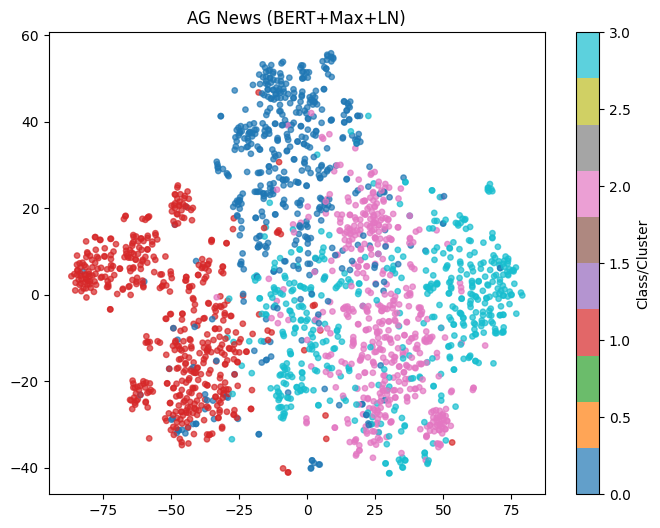

In [ ]:
# Run BERT+Max+LN+KM on AG News
ag_texts, ag_labels = load_agnews(n_per_class=1000)
results_ag = run_bert_experiment(
    texts=ag_texts,
    labels=ag_labels,
    model_name="bert-base-uncased",
    pooling="max",
    norm_method="layernorm"
)

print("AG News (BERT+Max+LN+KM):")
print(f"  ACC: {results_ag['ACC']*100:.2f}%")
print(f"  NMI: {results_ag['NMI']*100:.2f}%")
print(f"  ARI: {results_ag['ARI']*100:.2f}%")

visualize_features(results_ag['X_norm'], ag_labels, title='AG News (BERT+Max+LN)')

Extracting BERT embeddings (bert-base-uncased) for 14000 texts...
Feature matrix: (14000, 768)
DBpedia (BERT+Max+LN+KM):
  ACC: 67.99%
  NMI: 73.65%
  ARI: 53.95%


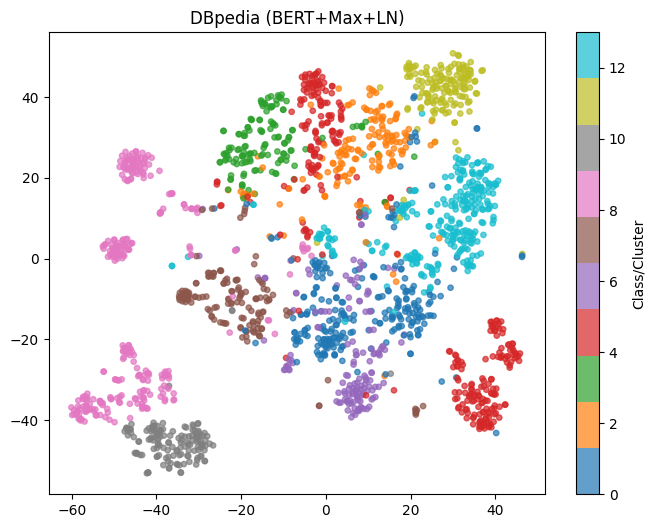

In [ ]:
# Run BERT+Max+LN+KM on DBpedia
db_texts, db_labels = load_dbpedia(n_per_class=1000)
results_db = run_bert_experiment(
    texts=db_texts,
    labels=db_labels,
    model_name="bert-base-uncased",
    pooling="max",
    norm_method="layernorm"
)

print("DBpedia (BERT+Max+LN+KM):")
print(f"  ACC: {results_db['ACC']*100:.2f}%")
print(f"  NMI: {results_db['NMI']*100:.2f}%")
print(f"  ARI: {results_db['ARI']*100:.2f}%")

visualize_features(results_db['X_norm'], db_labels, title='DBpedia (BERT+Max+LN)')

## 6.4 Experiments with Alternative Clustering Algorithms

To assess the robustness of the clustering results with respect to the choice of clustering algorithm, additional experiments are conducted by replacing **K-means** with an alternative clustering method, while keeping the feature extraction pipeline fixed.

In particular, **Agglomerative Clustering** is considered as a strong hierarchical baseline. Unlike K-means, agglomerative methods do not assume spherical cluster shapes and can capture more flexible cluster structures in the embedding space. The number of clusters is fixed to the ground-truth number of classes, enabling a direct comparison using the same evaluation metrics.

Agglomerative clustering is applied on the same deep feature representations used in previous experiments, with identical pooling and normalization strategies. Unless otherwise specified, the clustering is performed using a standard linkage criterion, and the resulting cluster assignments are evaluated using **Clustering Accuracy (ACC)**, **Normalized Mutual Information (NMI)**, and **Adjusted Rand Index (ARI)**.

This experimental setting allows for a controlled comparison between **K-means** and **Agglomerative Clustering**, isolating the effect of the clustering algorithm from that of the underlying document representations.


Results on AG News (ELMo + Mean + LayerNorm + Agglomerative Clustering):
ACC: 81.67%
NMI: 55.86%
ARI: 57.91%


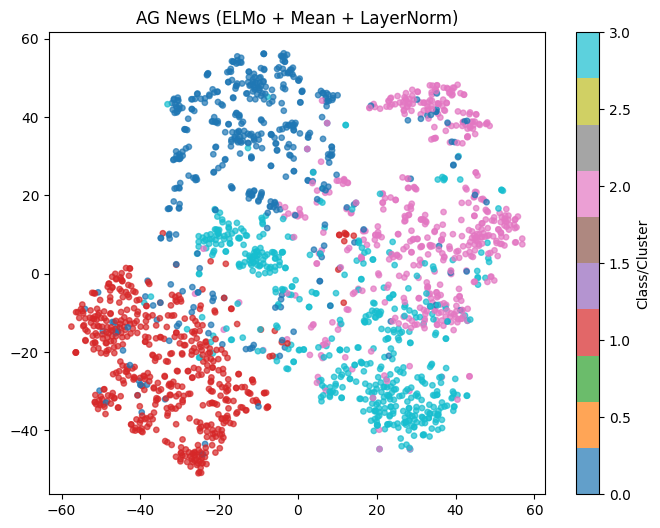

In [16]:
# Experiment 1: LM + Mean + LN + Agglomerative Clustering on AG News
texts, labels = load_agnews(n_per_class=1000)

X = extract_features(texts, model='elmo', pooling='mean')
X_norm = normalize_features(X, method="layernorm")

# Clustering with Agglomerative Clustering
y_pred, _ = cluster_features(X_norm, n_clusters=4, method="agglomerative")
acc = clustering_accuracy(labels, y_pred)
nmi = clustering_nmi(labels, y_pred)
ari = clustering_ari(labels, y_pred)

print(f"Results on AG News (ELMo + Mean + LayerNorm + Agglomerative Clustering):")
print(f"ACC: {acc*100:.2f}%")
print(f"NMI: {nmi*100:.2f}%")
print(f"ARI: {ari*100:.2f}%")

# Plot feature visualization
visualize_features(
    X_norm,
    labels,
    title='AG News (ELMo + Mean + LayerNorm)'
)

In [18]:
indication_words = tcre_explanation(texts, y_pred, top_n=10)

for cluster, words in indication_words.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Cluster 0: oil, google, shares, cuts, july, largest, airline, market, rose, profit
Cluster 1: space, iraq, computer, scientists, shares, oil, police, man, wildlife, rose
Cluster 2: iraq, police, minister, election, president, murder, army, rebels, leader, troops
Cluster 3: season, athens, olympics, football, league, company, victory, players, win, right
